In [1]:
import os
import math
import time
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import Sequential, utils, regularizers, Model, Input
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPool1D, Dropout, AvgPool1D
# from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

In [2]:
# 加载训练集和测试集(相对路径)
train = pd.read_csv('train.csv')
test = pd.read_csv('testA.csv')

In [3]:
# 数据精度量化压缩
def reduce_mem_usage(df):
    # 处理前 数据集总内存计算
    start_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    # 遍历特征列
    for col in df.columns:
        # 当前特征类型
        col_type = df[col].dtype
        # 处理 numeric 型数据
        if col_type != object:
            c_min = df[col].min()  # 最小值
            c_max = df[col].max()  # 最大值
            # int 型数据 精度转换
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            # float 型数据 精度转换
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        # 处理 object 型数据
        else:
            df[col] = df[col].astype('category')  # object 转 category
    
    # 处理后 数据集总内存计算
    end_mem = df.memory_usage().sum() / 1024**2 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# 训练集特征处理与精度量化
train_list = []
for items in train.values:
    train_list.append([items[0]] + [float(i) for i in items[1].split(',')] + [items[2]])
train = pd.DataFrame(np.array(train_list))
train.columns = ['id'] + ['s_' + str(i) for i in range(len(train_list[0])-2)] + ['label']  # 特征分离
train = reduce_mem_usage(train)  # 精度量化


# 测试集特征处理与精度量化
test_list=[]
for items in test.values:
    test_list.append([items[0]] + [float(i) for i in items[1].split(',')])
test = pd.DataFrame(np.array(test_list))
test.columns = ['id'] + ['s_'+str(i) for i in range(len(test_list[0])-1)]  # 特征分离
test = reduce_mem_usage(test)  # 精度量化

Memory usage of dataframe is 157.93 MB
Memory usage after optimization is: 39.67 MB
Decreased by 74.9%
Memory usage of dataframe is 31.43 MB
Memory usage after optimization is: 7.90 MB
Decreased by 74.9%


In [4]:
# 查看训练集, 分离标签与样本, 去除 id
y_train = train['label']
x_train = train.drop(['id', 'label'], axis=1)
print(x_train.shape, y_train.shape)

# 查看测试集, 去除 id
X_test = test.drop(['id'], axis=1)
print(X_test.shape)

print(train.info)
# 将测试集转换为适应 CNN 输入的 shape
# X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)
# print(X_test.shape, X_test.dtype)

(100000, 205) (100000,)
(20000, 205)
<bound method DataFrame.info of             id       s_0       s_1       s_2       s_3       s_4       s_5  \
0          0.0  0.991211  0.943359  0.764648  0.618652  0.379639  0.190796   
1          1.0  0.971680  0.929199  0.572754  0.178467  0.122986  0.132324   
2          2.0  1.000000  0.958984  0.701172  0.231812  0.000000  0.080688   
3          3.0  0.975586  0.934082  0.659668  0.249878  0.237061  0.281494   
4          4.0  0.000000  0.055817  0.261230  0.359863  0.433105  0.453613   
...        ...       ...       ...       ...       ...       ...       ...   
99995  99995.0  1.000000  0.677734  0.222412  0.257080  0.204712  0.054657   
99996  99996.0  0.926758  0.906250  0.637207  0.415039  0.374756  0.382568   
99997  99997.0  0.925781  0.587402  0.633301  0.632324  0.639160  0.614258   
99998  99998.0  1.000000  0.994629  0.829590  0.458252  0.264160  0.240234   
99999  99999.0  0.925781  0.916504  0.404297  0.000000  0.262939  0.38549

# 3. 数据探索性分析

## 3.1 基本分析

In [5]:
train.head()

,id,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_196,s_197,s_198,s_199,s_200,s_201,s_202,s_203,s_204,label
0,0.0,0.991211,0.943359,0.764648,0.618652,0.379639,0.190796,0.040222,0.026001,0.031708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.971680,0.929199,0.572754,0.178467,0.122986,0.132324,0.094421,0.089600,0.030487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.000000,0.958984,0.701172,0.231812,0.000000,0.080688,0.128418,0.187500,0.280762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3.0,0.975586,0.934082,0.659668,0.249878,0.237061,0.281494,0.249878,0.249878,0.241455,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.000000,0.055817,0.261230,0.359863,0.433105,0.453613,0.499023,0.542969,0.616699,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [6]:
test.head()

,id,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_195,s_196,s_197,s_198,s_199,s_200,s_201,s_202,s_203,s_204
0,100000.0,0.991699,1.000000,0.631836,0.136230,0.041412,0.102722,0.120850,0.123413,0.107910,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,100001.0,0.607422,0.541504,0.340576,0.000000,0.090698,0.164917,0.195068,0.168823,0.198853,...,0.389893,0.386963,0.367188,0.364014,0.360596,0.357178,0.350586,0.350586,0.350586,0.36377
2,100002.0,0.975098,0.670898,0.686523,0.708496,0.718750,0.716797,0.720703,0.701660,0.596680,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,100003.0,0.995605,0.916992,0.520996,0.000000,0.221802,0.404053,0.490479,0.527344,0.518066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,100004.0,1.000000,0.888184,0.745605,0.531738,0.380371,0.224609,0.091125,0.057648,0.003914,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [7]:
train.describe()

,id,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_196,s_197,s_198,s_199,s_200,s_201,s_202,s_203,s_204,label
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,...,100000.0,100000.0,100000.000000,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
mean,49999.500000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN
std,28867.658203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,24999.750000,0.913086,0.694824,0.346436,0.096191,0.129883,0.134521,0.112183,0.101013,0.100586,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,49999.500000,0.984375,0.859375,0.548828,0.282471,0.238037,0.245850,0.226562,0.233765,0.235352,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,74999.250000,1.000000,0.933105,0.685547,0.519531,0.431396,0.443115,0.450439,0.432373,0.396484,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0
max,99999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,0.983887,1.0,1.0,1.0,1.0,1.0,1.0,3.0


In [8]:
test.describe()

,id,s_0,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,...,s_195,s_196,s_197,s_198,s_199,s_200,s_201,s_202,s_203,s_204
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,109999.500000,0.872559,0.772461,0.514648,0.323242,0.301270,0.303955,0.292725,0.281738,0.270996,...,0.008499,0.007965,0.007450,0.007214,0.006939,0.006599,0.006386,0.005981,0.005295,0.005150
std,5773.646973,0.263916,0.237549,0.241699,0.256592,0.226685,0.215088,0.218262,0.212036,0.200073,...,0.061371,0.059784,0.058044,0.056641,0.056061,0.054382,0.053833,0.051910,0.048462,0.047272
min,100000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,104999.750000,0.910645,0.690918,0.341003,0.097336,0.129272,0.134155,0.111816,0.101379,0.100403,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,109999.500000,0.983887,0.857422,0.545410,0.279785,0.237305,0.247437,0.227722,0.233765,0.236694,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,114999.250000,1.000000,0.932617,0.683105,0.515137,0.429199,0.443848,0.451904,0.436523,0.401123,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,119999.000000,1.000000,1.000000,1.000000,0.998535,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.978516,1.000000,1.000000,1.000000,0.990234,0.999023,0.843262


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 207 entries, id to label
dtypes: float16(206), float32(1)
memory usage: 39.7 MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 206 entries, id to s_204
dtypes: float16(205), float32(1)
memory usage: 7.9 MB


综上可知：
1. 主要的特征数据为 1 维信号振幅 (已被归一化至 0～1 了)，总长度均为 205 (205 个时间节点/心跳节拍)
2. 同时，除波形数据外，没有任何辅助或先验信息可以利用
3. 波形数据均已被量化为 float16 类型的数值型特征，且没有类别型特征需要考虑
4. 没有缺失值，无需填充，非常理想 —— 事实上，未采集到的信号默认振幅就是 0，故不存在缺失值的问题
5. 显然，这类非表格数据更适合用神经网络来处理，而非传统机器学习模型

In [11]:
train['s_2'].isnull().any()

False

## 3.2 查看类别分布

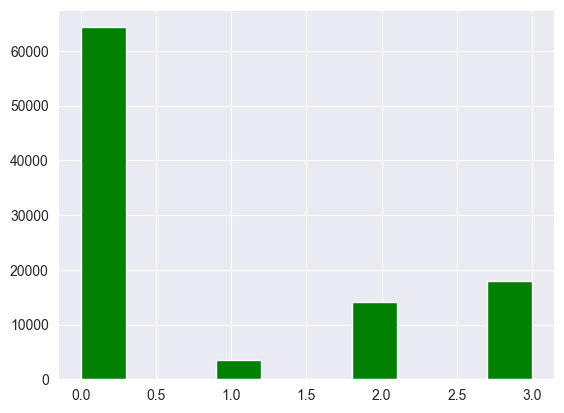

In [12]:
plt.hist(train['label'], orientation = 'vertical', histtype = 'bar', color = 'green')
plt.show() 

可见，训练-验证集中存在 **严重的类别不平衡问题**。为此，有多种方式应对(https://blog.csdn.net/qq_39478403/article/details/115533295)。

试了很多种方法，最后发现还是用 SMOTE 对少数类别上采样效果最好：

## 使用GMM进行分类

In [17]:
from scipy.stats import multivariate_normal
np.seterr(divide='ignore',invalid='ignore')

batch_size = 50

def e_step(data, prior, mu, sigma):
    data.info()
    (N, D) = data.shape
    print(N, D)
    K = len(prior)  # 分为K类
    gama_mat = np.zeros((N, K))
    for i in range(0, N):
        print('第', i + 1, '条数据')   
    
        xi = data.loc[i]  # 获取第i个数据点的特征向量
        _sum = 0
        for k in range(0, K):
            # 计算第i个数据点属于第k个聚类的概率密度，使用多元正态分布的概率密度函数
            p = multivariate_normal.pdf(xi, mu[k, :], sigma[k, :, :], True)
            _sum += prior[k] * p

        for k in range(0, K):
            gama_mat[i, k] = prior[k] * multivariate_normal.pdf(xi, mu[k, :], sigma[k, :, :], True) / _sum

    return gama_mat


def m_step(data, gama_mat):
    (N, D) = data.shape
    K = np.size(gama_mat, 1)
    mu = np.zeros((K, D))
    sigma = np.zeros((K, D, D))
    prior = np.zeros(K)

    for k in range(0, K):
        print('k:', k)
        # 计算第 k 个聚类的数据点数量，即后验概率矩阵 gama_mat 在第 k 列的和
        N_k = np.sum(gama_mat, 0)[k]
        for i in range(0, N):
            # 根据后验概率矩阵 gama_mat 中第 i 行、第 k 列的值，将第 i 个数据点的特征向量乘以该值，并累加到第 k 个聚类的均值 mu[k]上。
            mu[k] += gama_mat[i, k] * data.loc[i]
            print(mu[k])
        mu[k] /= N_k

        for i in range(0, N):
            # 计算数据点 X[i] 减去第 k 个聚类的均值 mu[k]，并将结果重塑为 (D, 1) 的矩阵
            left = np.reshape((data.loc[i] - mu[k]), (D, 1))
            # 计算数据点 X[i] 减去第 k 个聚类的均值 mu[k]，并将结果重塑为 (1, D) 的矩阵
            right = np.reshape((data.loc[i] - mu[k]), (1, D))
            '''
            根据后验概率矩阵 gama_mat 中第 i 行、第 k 列的值，将左乘矩阵 left 与右乘矩阵 right 相乘，
            并乘以该值，累加到第 k 个聚类的协方差矩阵 sigma[k] 上
            '''
            sigma[k] += gama_mat[i, k] * left * right
        sigma[k] /= N_k
        prior[k] = N_k / N

    return mu, sigma, prior


def logLike(data, prior, Mu, Sigma):
    K = len(prior)
    N, M = np.shape(data)
    # P is an NxK matrix where (i,j)th element represents the likelihood of
    # the ith datapoint to be in jth Cluster
    P = np.zeros([N, K])
    for k in range(K):
        for i in range(N):
            P[i, k] = multivariate_normal.pdf(data.loc[i], Mu[k, :], Sigma[k, :, :])
    return np.sum(np.log(P.dot(prior)))

In [18]:
# x_batch = x_train.head(batch_size)
N, D = x_train.shape
print(N, D)
K = 4

# initialization
mu = np.zeros((K, D), dtype=np.float32)
sigma = np.zeros((K, D, D), dtype=np.float32)
print('mu:', mu.shape)
print('sigma:', sigma.shape)

100000 205
mu: (4, 205)
sigma: (4, 205, 205)


In [19]:
mu = np.random.randint(0, 2, size=(K, D))

for k in range(0, K):
    # 生成随机下三角矩阵
    lower_triangular = np.random.rand(D, D)
    lower_triangular[np.triu_indices(D, k=1)] = 0.0
    
    # 构造正定矩阵
    diagonal = np.diag(np.random.uniform(low=0.1, high=1.0, size=D))
    covariance_matrix = np.dot(np.dot(lower_triangular, diagonal), lower_triangular.T)
    sigma[k] = covariance_matrix  # 更新 sigma[k]

prior = np.ones(K) / K
iteration = 0
prevail = -999999
ll_evol = []

print('initialization of the params:')
print('mu:', mu.shape)
print('sigma:', sigma.shape)
print('prior:', prior)

# print(x_train.iloc[1])

initialization of the params:
mu: (4, 205)
sigma: (4, 205, 205)
prior: [0.25 0.25 0.25 0.25]


In [20]:
# Iterate with E-Step and M-step
while True:
    gamma_hat = e_step(x_train.head(100), prior, mu, sigma)
    mu, sigma, prior = m_step(x_train.head(100), gamma_hat)
    print(mu, sigma, prior)
    ll_train = logLike(x_train.head(100), prior, mu, sigma)
    print('iter:', iteration, 'log likelihood:', ll_train)
    ll_evol.append(ll_train)

    iteration = iteration + 1
    if iteration > 150 or abs(ll_train - prevail) < 0.01:
        break

    abs(ll_train - prevail)
    prevail = ll_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 205 entries, s_0 to s_204
dtypes: float16(205)
memory usage: 40.2 KB
100 205
第 1 条数据
第 2 条数据
第 3 条数据
第 4 条数据
第 5 条数据
第 6 条数据
第 7 条数据
第 8 条数据
第 9 条数据
第 10 条数据
第 11 条数据
第 12 条数据
第 13 条数据
第 14 条数据
第 15 条数据
第 16 条数据
第 17 条数据
第 18 条数据
第 19 条数据
第 20 条数据
第 21 条数据
第 22 条数据
第 23 条数据
第 24 条数据
第 25 条数据
第 26 条数据
第 27 条数据
第 28 条数据
第 29 条数据
第 30 条数据
第 31 条数据
第 32 条数据
第 33 条数据
第 34 条数据
第 35 条数据
第 36 条数据
第 37 条数据
第 38 条数据
第 39 条数据
第 40 条数据
第 41 条数据
第 42 条数据
第 43 条数据
第 44 条数据
第 45 条数据
第 46 条数据
第 47 条数据
第 48 条数据
第 49 条数据
第 50 条数据
第 51 条数据
第 52 条数据
第 53 条数据
第 54 条数据
第 55 条数据
第 56 条数据
第 57 条数据
第 58 条数据
第 59 条数据
第 60 条数据
第 61 条数据
第 62 条数据
第 63 条数据
第 64 条数据
第 65 条数据
第 66 条数据
第 67 条数据
第 68 条数据
第 69 条数据
第 70 条数据
第 71 条数据
第 72 条数据
第 73 条数据
第 74 条数据
第 75 条数据
第 76 条数据
第 77 条数据
第 78 条数据
第 79 条数据
第 80 条数据
第 81 条数据
第 82 条数据
第 83 条数据
第 84 条数据
第 85 条数据
第 86 条数据
第 87 条数据
第 88 条数据
第 89 条数据
第 90 条数据
第 91 条数据
第 92 条数据
第 93 条数据
第 94 条数据
第 95 条

ValueError: array must not contain infs or NaNs

In [25]:
# 使用 SMOTE 对数据进行上采样以解决类别不平衡问题
smote = SMOTE(random_state=2021, n_jobs=-1)
k_x_train, k_y_train = smote.fit_resample(x_train, y_train)  
print(f"after smote, k_x_train.shape: {k_x_train.shape}, k_y_train.shape: {k_y_train.shape}")

# 将训练集转换为适应 CNN 输入的 shape
k_x_train = np.array(k_x_train).reshape(k_x_train.shape[0], k_x_train.shape[1], 1)

F:\anaconda\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


after smote, k_x_train.shape: (257308, 205), k_y_train.shape: (257308,)


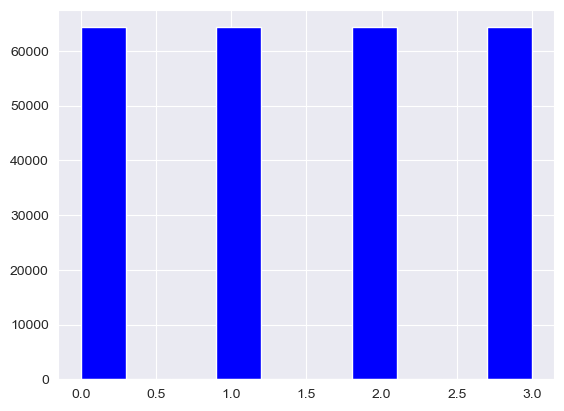

In [26]:
plt.hist(k_y_train, orientation = 'vertical', histtype = 'bar', color = 'blue')
plt.show() 